<a href="https://colab.research.google.com/github/atsss/kaggle_notebook/blob/main/ReNet50_dog_vs_cat_classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> https://www.kaggle.com/code/bhuvanchennoju/hey-siri-is-it-a-or-class-f1-0-992

## Download data

In [1]:
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [2]:
!kaggle competitions download -c dogs-vs-cats

In [3]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [4]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [5]:
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

## Import libraries

In [9]:
import warnings
warnings.filterwarnings('ignore')

# basic librareis
import zipfile
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image


# plotting and visualizations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

# preprocessing
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                       img_to_array,
                                       array_to_img,
                                       load_img)

from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             accuracy_score,
                             f1_score,
                             roc_auc_score)
# modeling
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

# model plotting
from IPython.display import SVG
from tensorflow.keras.utils import plot_model

# mesc
from sklearn.utils import shuffle

In [12]:
train_dir = '/content/train/'
test_dir  = '/content/test1/'

In [15]:
def category(path):
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

# image names and labels
x_train_imgname = filename(train_dir)
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

train_image_df = pd.DataFrame({ 'filename': x_train_imgname, 'category': y_train_label})
submission_image_df = pd.DataFrame({'filename': x_test_imgname})

In [16]:
train_image_df.head()

,filename,category
0,cat.8672.jpg,cat
1,cat.2613.jpg,cat
2,dog.4204.jpg,dog
3,dog.2710.jpg,dog
4,dog.7424.jpg,dog


In [17]:
submission_image_df.head()

,filename
0,4813.jpg
1,10213.jpg
2,513.jpg
3,275.jpg
4,9839.jpg


## Data visualization

In [18]:
def img_path(directory):
    paths = []
    cate = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        cate.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, cate




def showImages(data,num_row  = 3,num_col =  3, subtitle = 'off'):
    X, Y  = data['img_paths'], data['ID_no']     # could use try and except but lets stick to minimal code

    (X_rand, Y_rand) = shuffle(X, Y)

    # showing images on matplotlib

    fig, ax = plt.subplots(num_row,num_col,figsize = (12,12), dpi = 100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()

    for idx,ax  in enumerate(axes):
        x = load_img(X_rand.iloc[idx],target_size= (125, 125))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace =0)
        del x

    return None


In [19]:
ID_no, img_paths, train_images = img_path(train_dir)

visual_df = pd.DataFrame({'ID_no':ID_no,'Category':train_images, 'img_paths': img_paths})

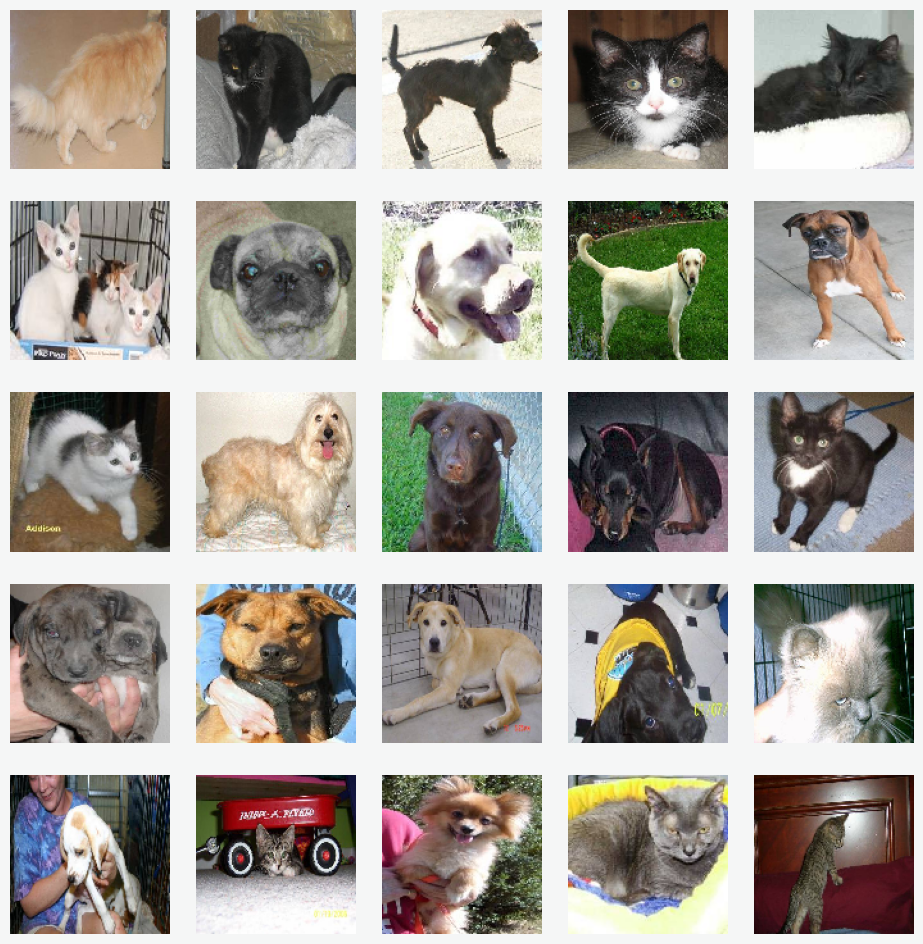

In [22]:
showImages(visual_df,5,5, subtitle = 'off')

In [24]:
train_valid_df, test_df = train_test_split(train_image_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
holdon_images = test_df.shape[0]
test_images = submission_image_df.shape[0]

print('train images:', train_images)
print('valid images:', valid_images)
print('holdon images:', holdon_images)
print('test images:', test_images)

train images: 19200
valid images: 4800
holdon images: 1000
test images: 12500


<Axes: xlabel='category'>

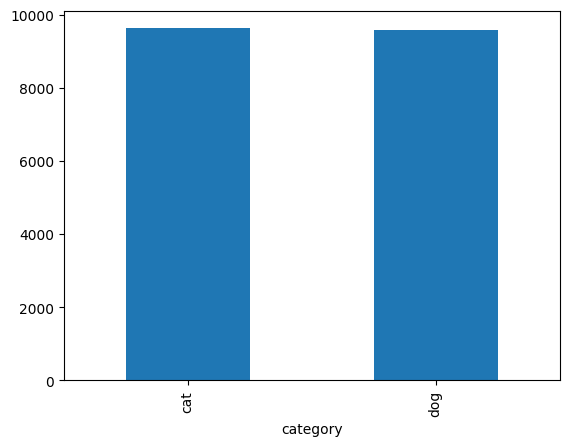

In [25]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

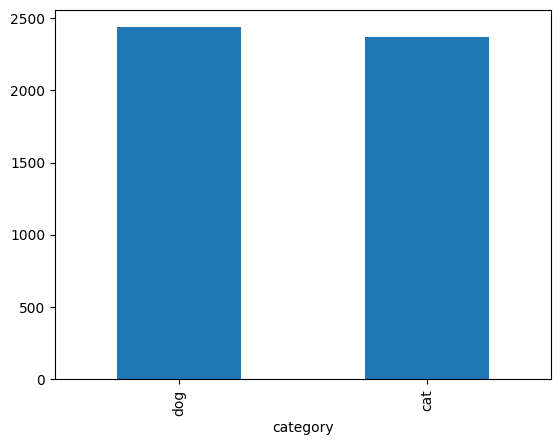

In [26]:
valid_df['category'].value_counts().plot.bar()

## Data Agumentation, Early Stopping, Learning Rate Schedule

In [29]:
img_size = 224
batch_size = 128

In [30]:
def data_argumentation_show(n, grid_size):
    sample_aug_map = ImageDataGenerator(
            #zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255)
    sample_data = sample_aug_map.flow_from_dataframe(
            (train_df.sample(n)),
            train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            class_mode = 'categorical')

    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
            del img
    fig.show()

    return None


Found 1 validated image filenames belonging to 1 classes.


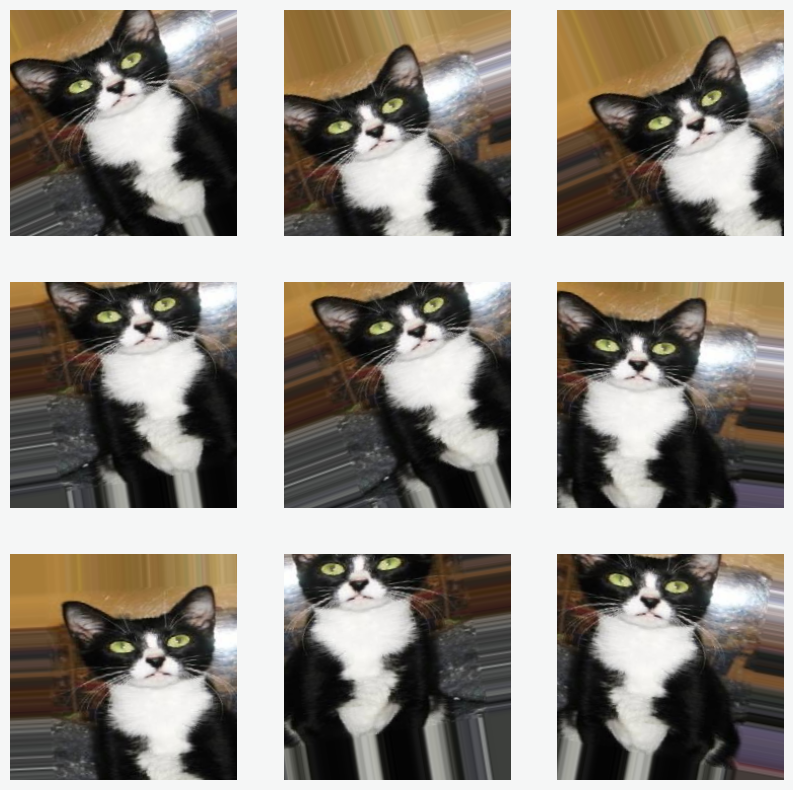

In [32]:
data_argumentation_show(1, 3)

In [33]:
epoch = 50
learning_rate = 3e-5
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

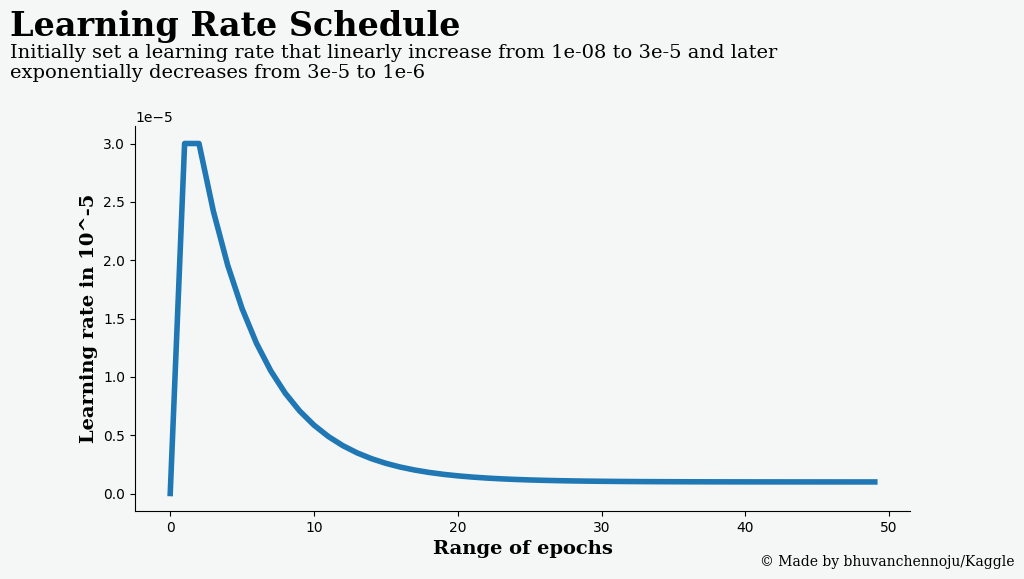

In [36]:
epochs = 20
epochs_range = [i for i in range(50 if epochs<50 else epochs)]
learn_rate = [lrfn(x) for x in epochs_range]


fig,ax = plt.subplots(figsize = (10,5))
fig.patch.set_facecolor('#f5f6f6')
ax.set_facecolor('#f5f6f6')

for loc in ['right','top',]:
    ax.spines[loc].set_visible(False)

ax.plot(epochs_range, learn_rate, linewidth = 4)
plt.xlabel('Range of epochs',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})
plt.ylabel('Learning rate in 10^-5',{'fontfamily':'serif', 'size':14,  'color':'black', 'weight':'bold'})


plt.gcf().text(0,1.06,'Learning Rate Schedule',{'fontfamily':'serif', 'size':24,  'color':'black', 'weight':'bold'})
plt.gcf().text(0,0.975,"""Initially set a learning rate that linearly increase from 1e-08 to 3e-5 and later
exponentially decreases from 3e-5 to 1e-6""",{'fontfamily':'serif', 'size':14,  'color':'black', })

plt.gcf().text(0.75,0,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()


## Classification with ResNet50

In [37]:
train_aug_map = ImageDataGenerator(
                    rotation_range=10,
                    #zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #width_shift_range=0.1,
                    #height_shift_range=0.1,
                    preprocessing_function = preprocess_input)
res_train_data = train_aug_map.flow_from_dataframe(
            train_df, train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')

#one should validate the generality of model on the actcual target images
#so not supposed agumentation
valid_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


#test data rescaling images

test_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


In [38]:
resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224,224, 3))

resNet.trainable = False # Freeze layers
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])


optimizer = optimizers.Adam(1e-5)

resNet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,351,234 (481.99 MB)

 Trainable params: 102,763,522 (392.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
earlystop = EarlyStopping(patience= 5)

lr_callback = LearningRateScheduler(lrfn, verbose = True)

callbacks = [earlystop, lr_callback]


In [40]:
resNet_model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [42]:
resnet_history = resNet_model.fit(res_train_data, epochs = 15,
                          validation_data = res_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 1e-08.
Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.4951 - loss: 1.8976 - val_accuracy: 0.5338 - val_loss: 1.3479 - learning_rate: 1.0000e-08

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.9239 - loss: 0.5456 - val_accuracy: 0.9861 - val_loss: 0.0794 - learning_rate: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9907 - loss: 0.0458 - val_accuracy: 0.9873 - val_loss: 0.0555 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9922 - loss: 0.0259 - val_accuracy: 0.9871 - val_loss: 0.0458 - learning_rate: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/15
150/150

## Evaluation

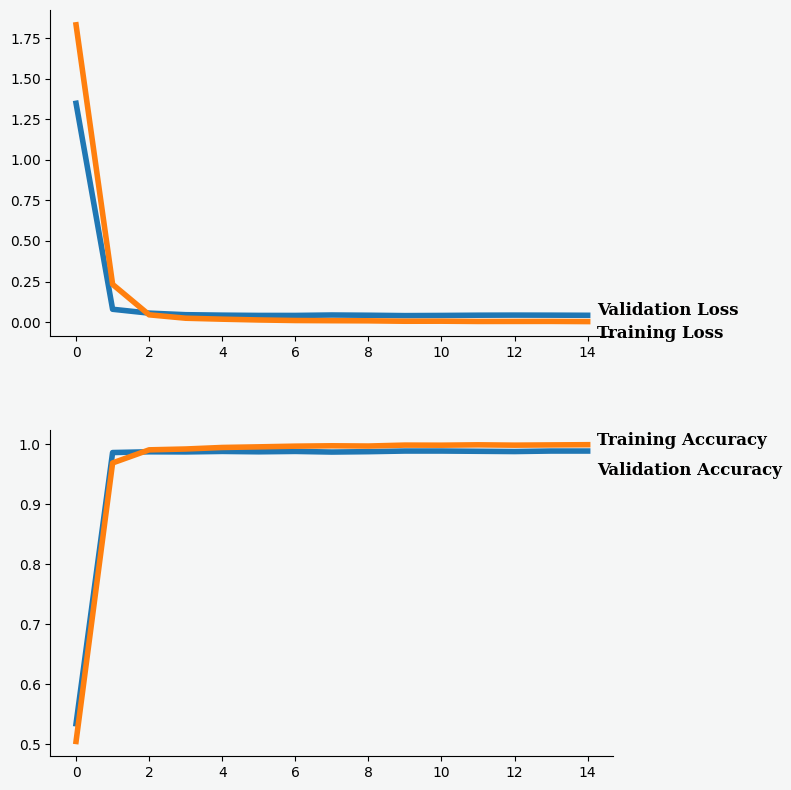

In [43]:
fig,ax  = plt.subplots(2,1, figsize =(8,8), dpi = 100)
fig.patch.set_facecolor('#f5f6f6')

axes  = ax.ravel()

for ax in axes:
    ax.set_facecolor('#f5f6f6')
    for loc in ['right','top',]:
        ax.spines[loc].set_visible(False)

hist2 = resnet_history.history
Epochs =  range(len(hist2['loss']))

## loss plot
sns.lineplot(x = Epochs, y = hist2['val_loss'],  ax = axes[0], linewidth = 4)
sns.lineplot(x = Epochs, y = hist2['loss'], ax  = axes[0], linewidth =4)
axes[0].text(Epochs[-1]+0.25,hist2['val_loss'][-1],'Validation Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold'})
axes[0].text(Epochs[-1]+0.25,hist2['loss'][-1]-0.1 ,'Training Loss',{'fontfamily':'serif', 'size':12, 'weight':'bold'})


# accuracy plot
sns.lineplot(x = Epochs, y = hist2['val_accuracy'],ax = axes[1],linewidth = 4)
sns.lineplot(x = Epochs, y = hist2['accuracy'],ax = axes[1],linewidth =4)
axes[1].text(Epochs[-1]+0.25,hist2['val_accuracy'][-1]-0.04,'Validation Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold'})
axes[1].text(Epochs[-1]+0.25,hist2['accuracy'][-1] ,'Training Accuracy',{'fontfamily':'serif', 'size':12, 'weight':'bold'})


plt.tight_layout(h_pad = 5)

fig.show()

In [44]:
res_pred = resNet_model.predict(res_test_data)
test_df['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_df['res_pred'] = test_df['res_pred'].map(labels)

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step


In [45]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,annot_kws={'fontfamily':'serif','size':18,'weight':'bold'},
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label', **{'fontfamily':'serif','size':12,'weight':'bold'})
        plt.xlabel('Predicted label' + stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    else:
        plt.xlabel(stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})

    plt.gca().set_xticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})
    plt.gca().set_yticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})


TypeError: Axis.set_ticklabels() takes 2 positional arguments but 3 were given

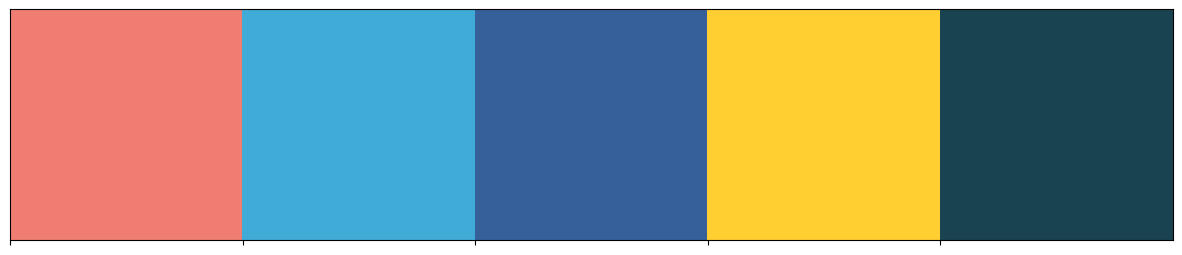

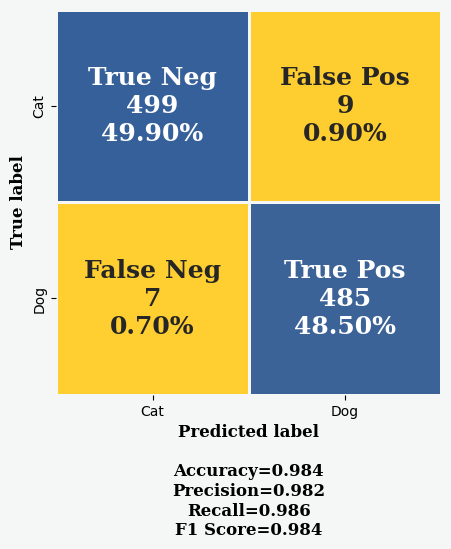

In [46]:
colors = ['#EF7D71','#41ABD7','#36609A','#FFCE30','#194350']
sns.palplot(colors,size = 3)

res_cf_matrix = confusion_matrix(test_df['category'],test_df['res_pred'])
my_cols = [colors[3],colors[2]]

labels = [ 'True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(res_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",my_cols),
                      categories=categories,
                      title = 'Vanila CNN comfusion matrix')

plt.gcf().text(0.85,-0.15,'© Made by bhuvanchennoju/Kaggle',{'fontfamily':'serif', 'size':10,  'color':'black'})
plt.gcf().show()
